In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from climada.hazard import Hazard

tc_wind = Hazard.from_hdf5("./data/tc_wind/tc_wind_SHANSHAN_20240825000000.hdf5")

In [3]:
import numpy as np
from climada.util.coordinates import get_country_code

country_code_all = get_country_code(tc_wind.centroids.lat, tc_wind.centroids.lon)
country_code_unique = np.trim_zeros(np.unique(country_code_all))


In [4]:
from climada.entity import ImpactFunc, ImpactFuncSet

def impf_step_func(threshold: float = 32.92):

    impf = ImpactFunc.from_step_impf((0,threshold, 100),
                                     haz_type="TC")
    
    impf_set = ImpactFuncSet()
    impf_set.append(impf)

    return(impf_set)

2024-11-26 16:40:44,629 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 494248 coordinates.
2024-11-26 16:40:54,581 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 28 coordinates.
2024-11-26 16:40:54,584 - climada.engine.impact_calc - WARNING - No exposures with value >0 in the vicinity of the hazard.
2024-11-26 16:40:56,821 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 28 coordinates.
2024-11-26 16:40:56,824 - climada.engine.impact_calc - WARNING - No exposures with value >0 in the vicinity of the hazard.
2024-11-26 16:41:24,750 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 1572514 coordinates.
2024-11-26 16:41:24,866 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 6905 coordinates.
2024-11-26 16:41:37,427 - climada.util.coordinates - WARNING - Distance t

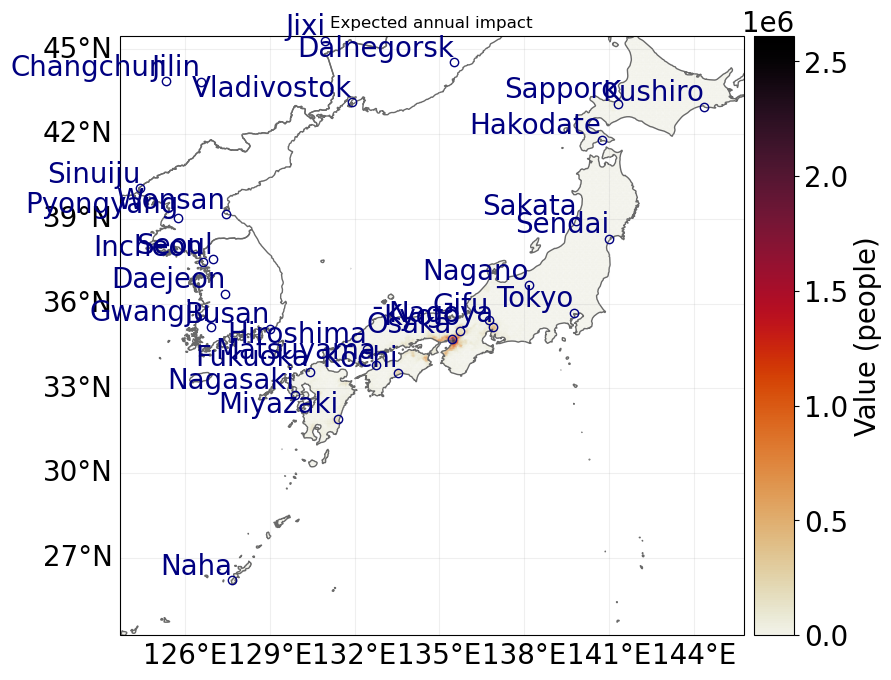

In [5]:
from climada.engine import ImpactCalc
from climada.util.api_client import Client
client = Client()

impf_set_step = impf_step_func()

for country_code in country_code_unique:
    try:
        exp = client.get_exposures(exposures_type='litpop',
                                properties={'country_iso3num':[str(country_code)],
                                            'exponents':'(0,1)',
                                            'fin_mode':'pop',
                                            'version':'v2'
                                            }
                                )
    except client.NoResult:
        f"there is no matching dataset in Data API. Country code: {country_code}"
    
    imp_exposed = ImpactCalc(exp, impf_set_step, tc_wind).impact()

    if imp_exposed.aai_agg == 0.0:
        continue
    else:
        imp_exposed.plot_hexbin_eai_exposure()

In [6]:
imp_exposed.aai_agg

0.0